<a href="https://colab.research.google.com/github/seoyeonaa/practice/blob/main/sweetcide_weather_AUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import package

In [ ]:
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/실습/data/weatherAUS.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

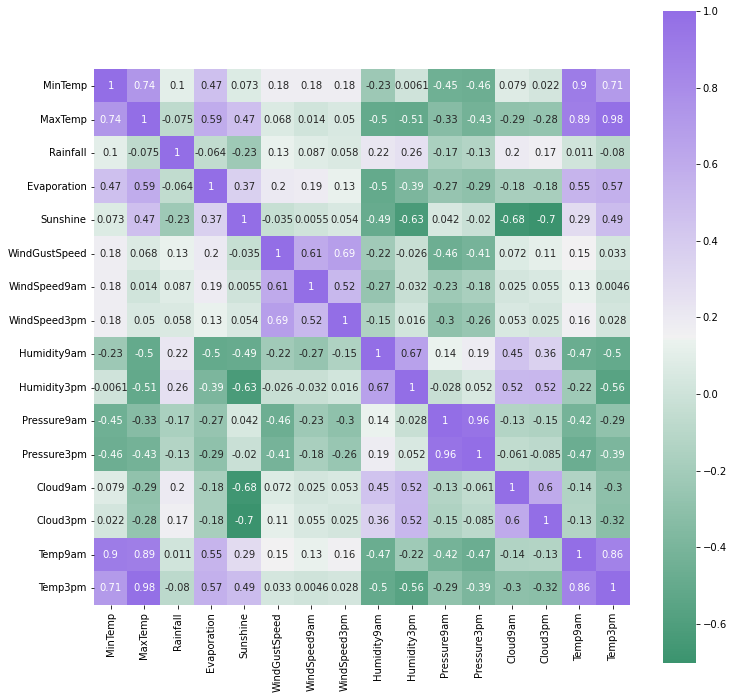

In [ ]:
# 상관계수
corrmat = data.corr()
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

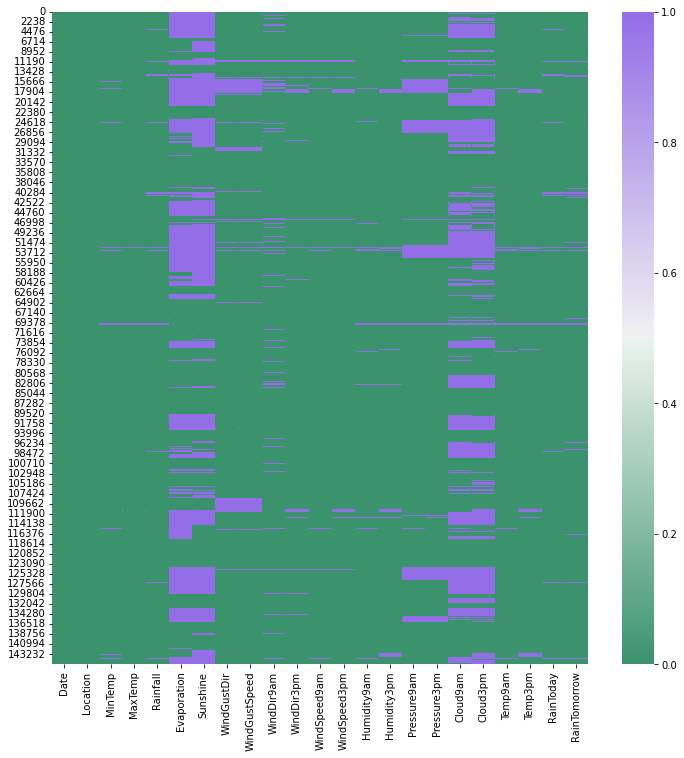

In [ ]:
plt.subplots(figsize=(12,12))
sns.heatmap(data.isnull(),cmap= cmap)

In [ ]:
#Evaporation, Sunshine, Cloud9am, Cloud3pm은 결측값이 너무 많으므로 제외
data = data.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis = 1)

In [ ]:
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [ ]:
data['Date']= pd.to_datetime(data["Date"])
data['year'] = data.Date.dt.year

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Sine Encoded Months')

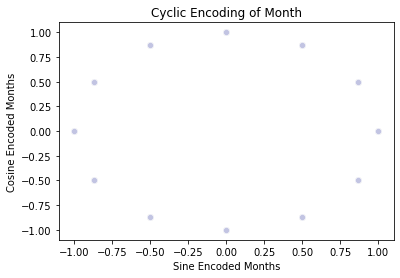

In [ ]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

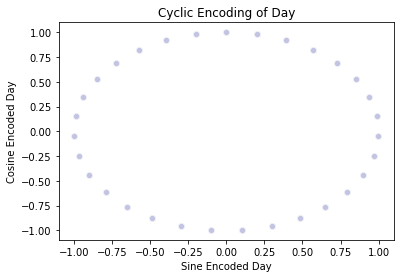

In [ ]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [ ]:
#필요없는 행 지우기
data = data.drop(['Date','year', 'month','day'], axis = 1)

## 범주형 변수 선택

In [ ]:
obj_cols_1 = data.select_dtypes(include=['object'])
obj_cols_2 = pd.DataFrame(obj_cols_1)
obj_cols = obj_cols_2.columns.tolist()
print("Categorical variables:")
print(obj_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


## 연속형 변수 선택

In [ ]:
num_cols_1 = data.select_dtypes(exclude=['object'])
num_cols_2 = pd.DataFrame(num_cols_1)
num_cols = num_cols_2.columns.tolist()
print("Numerical variables:")
print(num_cols)

Numerical variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [ ]:
for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

In [ ]:
for i in obj_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [ ]:
data.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,month_sin,month_cos,day_sin,day_cos
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,-2.449294e-16,1.0,0.201299,0.979530
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,-2.449294e-16,1.0,0.394356,0.918958
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,-2.449294e-16,1.0,0.571268,0.820763
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,-2.449294e-16,1.0,0.724793,0.688967
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,-2.449294e-16,1.0,0.848644,0.528964


## 결측값 대체

In [ ]:
label_encoder = LabelEncoder()
for i in obj_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.head(3)

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,month_sin,month_cos,day_sin,day_cos
0,2,13.4,22.9,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0,-2.449294e-16,1.0,0.201299,0.979530
1,2,7.4,25.1,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0,-2.449294e-16,1.0,0.394356,0.918958
2,2,12.9,25.7,0.0,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0,-2.449294e-16,1.0,0.571268,0.820763


## 데이터 전처리



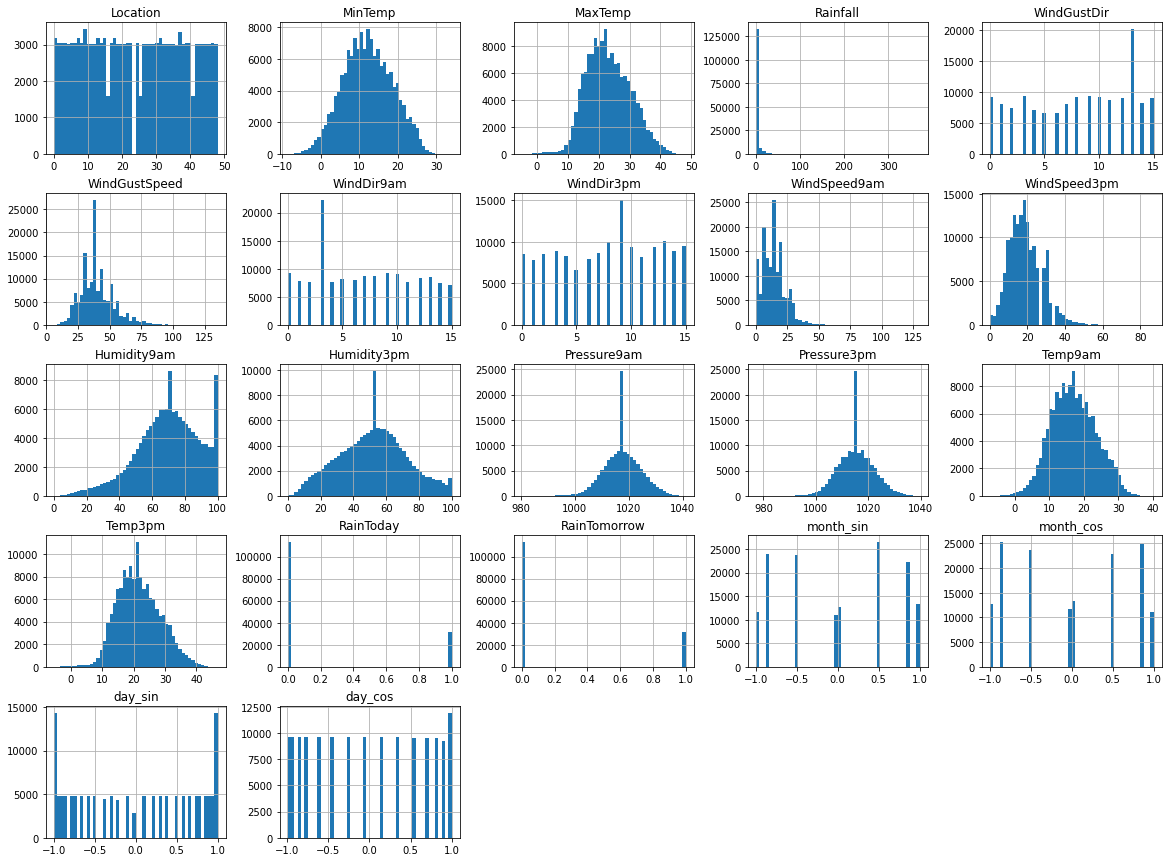

In [ ]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
weather_train = data

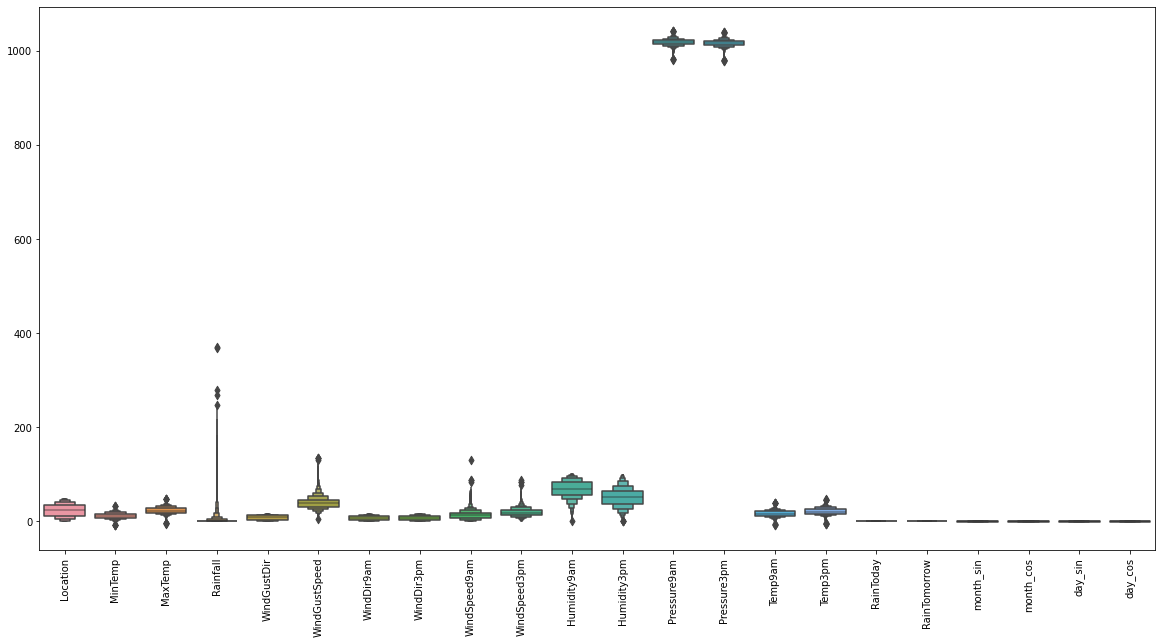

In [ ]:
#수치형 변수에 대한 standard scale
#boxplot을 보고 스케일러 결정 (이상치 많거나 히스토그램 보고 확인)

plt.figure(figsize=(20,10))
sns.boxenplot(data = weather_train)
plt.xticks(rotation=90)
plt.show()

멈춤

In [ ]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  int64  
 1   MinTemp        145460 non-null  float64
 2   MaxTemp        145460 non-null  float64
 3   Rainfall       145460 non-null  float64
 4   WindGustDir    145460 non-null  int64  
 5   WindGustSpeed  145460 non-null  float64
 6   WindDir9am     145460 non-null  int64  
 7   WindDir3pm     145460 non-null  int64  
 8   WindSpeed9am   145460 non-null  float64
 9   WindSpeed3pm   145460 non-null  float64
 10  Humidity9am    145460 non-null  float64
 11  Humidity3pm    145460 non-null  float64
 12  Pressure9am    145460 non-null  float64
 13  Pressure3pm    145460 non-null  float64
 14  Temp9am        145460 non-null  float64
 15  Temp3pm        145460 non-null  float64
 16  RainToday      145460 non-null  int64  
 17  RainTomorrow   145460 non-nul

In [ ]:
numv_weather_train = data.drop(obj_cols, axis = 1)

In [ ]:
objv_weather_train = data[obj_cols]

In [ ]:
data.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,month_sin,month_cos,day_sin,day_cos
0,2,13.4,22.9,0.6,13,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0,-2.449294e-16,1.0,0.201299,0.979530
1,2,7.4,25.1,0.0,14,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0,-2.449294e-16,1.0,0.394356,0.918958
2,2,12.9,25.7,0.0,15,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0,-2.449294e-16,1.0,0.571268,0.820763
3,2,9.2,28.0,0.0,4,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0,-2.449294e-16,1.0,0.724793,0.688967
4,2,17.5,32.3,1.0,13,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0,-2.449294e-16,1.0,0.848644,0.528964


In [ ]:
col_names = num_cols
s_scaler = preprocessing.StandardScaler()
numv_weather_train = s_scaler.fit_transform(numv_weather_train)
numv_weather_train = pd.DataFrame(numv_weather_train, columns=col_names)
numv_weather_train

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,month_sin,month_cos,day_sin,day_cos
0,0.189757,-0.044575,-0.203581,0.307739,0.673596,0.611499,0.111308,-1.443652,-1.478015,-1.223012,-0.013506,0.019135,-0.016425,1.434192,0.278970,1.426023
1,-0.752786,0.265794,-0.275097,0.307739,-1.131913,0.382054,-1.320650,-1.297105,-1.047010,-1.117969,0.033011,0.384064,-0.016425,1.434192,0.549587,1.339551
2,0.111212,0.350440,-0.275097,0.460168,0.560752,0.840944,-1.638863,-1.052860,-1.492877,-0.982915,0.622225,0.223495,-0.016425,1.434192,0.797572,1.199371
3,-0.470023,0.674917,-0.275097,-1.216548,-0.342003,-1.109339,-1.267615,-1.736746,-0.006653,-0.367666,0.172562,0.705202,-0.016425,1.434192,1.012774,1.011221
4,0.833828,1.281548,-0.155903,0.079096,-0.793380,0.152609,0.694699,-0.906314,-1.017286,-1.388078,0.126045,1.172312,-0.016425,1.434192,1.186382,0.782805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,-1.475402,0.025964,-0.275097,-0.683048,-0.116314,-0.879894,-0.949402,-1.345954,1.033703,0.757789,-1.067887,0.106718,-0.016425,-1.388032,-1.261688,-0.601030
145456,-1.349730,0.294010,-0.275097,-1.368977,-0.116314,-1.109339,-0.684224,-1.492501,0.870219,0.577716,-0.943842,0.413259,-0.016425,-1.388032,-1.360192,-0.330159
145457,-1.066967,0.519733,-0.275097,-0.225761,-0.567692,-1.109339,-0.843331,-1.345954,0.498663,0.232577,-0.695753,0.646814,-0.016425,-1.388032,-1.403140,-0.044639
145458,-0.689950,0.533840,-0.275097,-0.911691,-0.116314,-1.338784,-0.949402,-1.345954,0.260867,0.187559,-0.292607,0.632217,-0.016425,-1.388032,-1.388775,0.243842


In [ ]:
numv_weather_train = pd.concat([numv_weather_train,objv_weather_train],axis=1)
numv_weather_train = pd.DataFrame(numv_weather_train)
numv_weather_train

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,month_sin,month_cos,day_sin,day_cos,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,0.189757,-0.044575,-0.203581,0.307739,0.673596,0.611499,0.111308,-1.443652,-1.478015,-1.223012,-0.013506,0.019135,-0.016425,1.434192,0.278970,1.426023,2,13,13,14,0,0
1,-0.752786,0.265794,-0.275097,0.307739,-1.131913,0.382054,-1.320650,-1.297105,-1.047010,-1.117969,0.033011,0.384064,-0.016425,1.434192,0.549587,1.339551,2,14,6,15,0,0
2,0.111212,0.350440,-0.275097,0.460168,0.560752,0.840944,-1.638863,-1.052860,-1.492877,-0.982915,0.622225,0.223495,-0.016425,1.434192,0.797572,1.199371,2,15,13,15,0,0
3,-0.470023,0.674917,-0.275097,-1.216548,-0.342003,-1.109339,-1.267615,-1.736746,-0.006653,-0.367666,0.172562,0.705202,-0.016425,1.434192,1.012774,1.011221,2,4,9,0,0,0
4,0.833828,1.281548,-0.155903,0.079096,-0.793380,0.152609,0.694699,-0.906314,-1.017286,-1.388078,0.126045,1.172312,-0.016425,1.434192,1.186382,0.782805,2,13,1,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,-1.475402,0.025964,-0.275097,-0.683048,-0.116314,-0.879894,-0.949402,-1.345954,1.033703,0.757789,-1.067887,0.106718,-0.016425,-1.388032,-1.261688,-0.601030,41,0,9,1,0,0
145456,-1.349730,0.294010,-0.275097,-1.368977,-0.116314,-1.109339,-0.684224,-1.492501,0.870219,0.577716,-0.943842,0.413259,-0.016425,-1.388032,-1.360192,-0.330159,41,6,9,3,0,0
145457,-1.066967,0.519733,-0.275097,-0.225761,-0.567692,-1.109339,-0.843331,-1.345954,0.498663,0.232577,-0.695753,0.646814,-0.016425,-1.388032,-1.403140,-0.044639,41,3,9,14,0,0
145458,-0.689950,0.533840,-0.275097,-0.911691,-0.116314,-1.338784,-0.949402,-1.345954,0.260867,0.187559,-0.292607,0.632217,-0.016425,-1.388032,-1.388775,0.243842,41,9,10,3,0,0


In [ ]:
numv_weather_train = numv_weather_train[(numv_weather_train["MinTemp"]<2.3)&(numv_weather_train["MinTemp"]>-2.3)]
numv_weather_train = numv_weather_train[(numv_weather_train["MaxTemp"]<2.3)&(numv_weather_train["MaxTemp"]>-2)]
numv_weather_train = numv_weather_train[(numv_weather_train["Rainfall"]<4.5)]
numv_weather_train = numv_weather_train[(numv_weather_train["WindGustSpeed"]<4)&(numv_weather_train["WindGustSpeed"]>-4)]
numv_weather_train = numv_weather_train[(numv_weather_train["WindSpeed9am"]<4)]
numv_weather_train = numv_weather_train[(numv_weather_train["WindSpeed3pm"]<2.5)]
numv_weather_train = numv_weather_train[(numv_weather_train["Humidity9am"]>-3)]
numv_weather_train = numv_weather_train[(numv_weather_train["Humidity3pm"]>-2.2)]
numv_weather_train = numv_weather_train[(numv_weather_train["Pressure9am"]< 2)&(numv_weather_train["Pressure9am"]>-2.7)]
numv_weather_train = numv_weather_train[(numv_weather_train["Pressure3pm"]< 2)&(numv_weather_train["Pressure3pm"]>-2.7)]
numv_weather_train = numv_weather_train[(numv_weather_train["Temp9am"]<2.3)&(numv_weather_train["Temp9am"]>-2)]
numv_weather_train = numv_weather_train[(numv_weather_train["Temp3pm"]<2.3)&(numv_weather_train["Temp3pm"]>-2)]

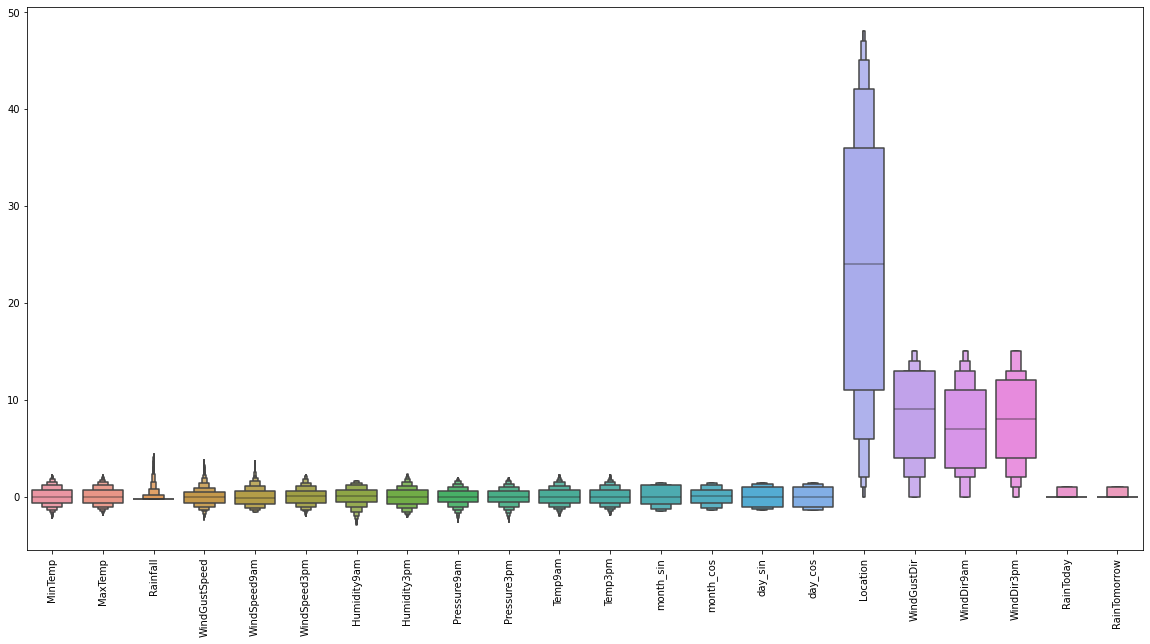

In [ ]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = numv_weather_train)
plt.xticks(rotation=90) #직각으로 바꿔줌
plt.show()

## modeling

In [ ]:
data = numv_weather_train

In [ ]:
X = data.drop(["RainTomorrow"], axis=1)
y = data["RainTomorrow"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(129292, 21)

In [ ]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 21))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size = 32, epochs = 10, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/10
2586/2586 [==============================] - 7s 3ms/step - loss: 0.5122 - accuracy: 0.7878 - val_loss: 0.4048 - val_accuracy: 0.7862
Epoch 2/10
2586/2586 [==============================] - 6s 2ms/step - loss: 0.4253 - accuracy: 0.8066 - val_loss: 0.3940 - val_accuracy: 0.8274
Epoch 3/10
2586/2586 [==============================] - 6s 2ms/step - loss: 0.4180 - accuracy: 0.8098 - val_loss: 0.3875 - val_accuracy: 0.8384
Epoch 4/10
2586/2586 [==============================] - 6s 2ms/step - loss: 0.4147 - accuracy: 0.8113 - val_loss: 0.3840 - val_accuracy: 0.8386
Epoch 5/10
2586/2586 [==============================] - 6s 2ms/step - loss: 0.4097 - accuracy: 0.8131 - val_loss: 0.3807 - val_accuracy: 0.8409
Epoch 6/10
2586/2586 [==============================] - 6s 2ms/step - loss: 0.4070 - accuracy: 0.8122 - val_loss: 0.3788 - val_accuracy: 0.8413
Epoch 7/10
2586/2586 [==============================] - 6s 2ms/step - loss: 0.4070 - accuracy: 0.8139 - val_loss: 0.3769 - val_accuracy:

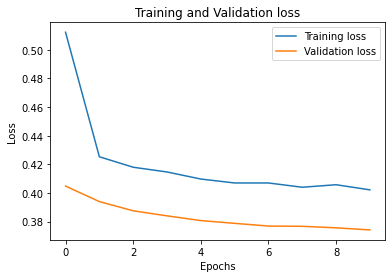

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

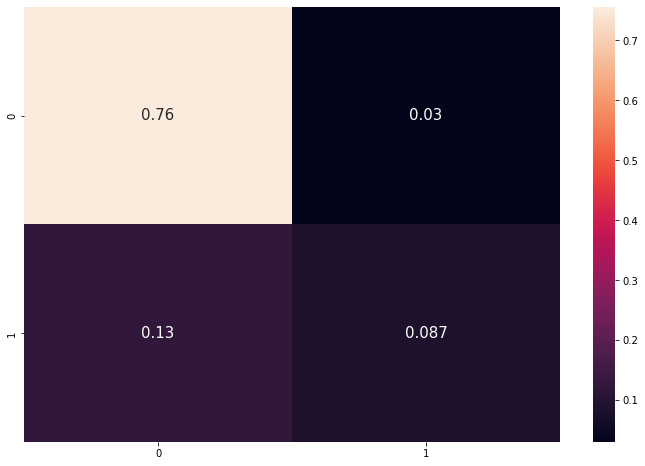

In [ ]:
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15})

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     20337
           1       0.74      0.41      0.53      5522

    accuracy                           0.84     25859
   macro avg       0.80      0.68      0.72     25859
weighted avg       0.83      0.84      0.82     25859

